In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Load dataset
bat = pd.read_csv('bat_final_data_preprocessed.csv')
brown_hare = pd.read_csv('brown_hare_final_data_preprocessed.csv')
dormice = pd.read_csv('dormice_final_data_preprocessed.csv')
hedgehog = pd.read_csv('hedgehog_final_data_preprocessed.csv')
red_squirrel = pd.read_csv('red_squirrel_final_data_preprocessed.csv')

bat['label'] = bat['type'].map({'presence': 1, 'background': 0})
brown_hare['label'] = brown_hare['type'].map({'presence': 1, 'background': 0})
dormice['label'] = dormice['type'].map({'presence': 1, 'background': 0})
hedgehog['label'] = hedgehog['type'].map({'presence': 1, 'background': 0})
red_squirrel['label'] = red_squirrel['type'].map({'presence': 1, 'background': 0})

#get all boolean columns and convert them to int
bat = bat.astype({col: 'int' for col in bat.select_dtypes(include='bool').columns})
brown_hare = brown_hare.astype({col: 'int' for col in brown_hare.select_dtypes(include='bool').columns})
dormice = dormice.astype({col: 'int' for col in dormice.select_dtypes(include='bool').columns})
hedgehog = hedgehog.astype({col: 'int' for col in hedgehog.select_dtypes(include='bool').columns})
red_squirrel = red_squirrel.astype({col: 'int' for col in red_squirrel.select_dtypes(include='bool').columns})


In [99]:
from sklearn.model_selection import train_test_split

bat_train_X, bat_test_X, bat_train_y, bat_test_y = train_test_split(
    bat.drop(columns=['type', 'label']),
    bat['label'],
    test_size=0.2,
    random_state=42
)
brown_hare_train_X, brown_hare_test_X, brown_hare_train_y, brown_hare_test_y = train_test_split(
    brown_hare.drop(columns=['type', 'label']),
    brown_hare['label'],
    test_size=0.2,
    random_state=42
)

dormice_train_X, dormice_test_X, dormice_train_y, dormice_test_y = train_test_split(
    dormice.drop(columns=['type', 'label']),
    dormice['label'],
    test_size=0.2,
    random_state=42
)

hedgehog_train_X, hedgehog_test_X, hedgehog_train_y, hedgehog_test_y = train_test_split(
    hedgehog.drop(columns=['type', 'label']),
    hedgehog['label'],
    test_size=0.2,
    random_state=42
)

red_squirrel_train_X, red_squirrel_test_X, red_squirrel_train_y, red_squirrel_test_y = train_test_split(
    red_squirrel.drop(columns=['type', 'label']),
    red_squirrel['label'],
    test_size=0.2,
    random_state=42
)

In [100]:
from sklearn.preprocessing import StandardScaler
import pickle

scaler = StandardScaler()
env_vars = ['BSI', 'LST', 'MNDWI', 'NDBI', 'NDSI', 'NDVI', 'NDWI', 'SAVI', 'UI']
bat_train_X[env_vars] = scaler.fit_transform(bat_train_X[env_vars])
bat_test_X[env_vars] = scaler.transform(bat_test_X[env_vars])
# save the scaler
with open('bat_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

brown_hare_train_X[env_vars] = scaler.fit_transform(brown_hare_train_X[env_vars])
brown_hare_test_X[env_vars] = scaler.transform(brown_hare_test_X[env_vars])
# save the scaler
with open('brown_hare_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

dormice_train_X[env_vars] = scaler.fit_transform(dormice_train_X[env_vars])
dormice_test_X[env_vars] = scaler.transform(dormice_test_X[env_vars])
# save the scaler
with open('dormice_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

hedgehog_train_X[env_vars] = scaler.fit_transform(hedgehog_train_X[env_vars])
hedgehog_test_X[env_vars] = scaler.transform(hedgehog_test_X[env_vars])
# save the scaler
with open('hedgehog_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

red_squirrel_train_X[env_vars] = scaler.fit_transform(red_squirrel_train_X[env_vars])
red_squirrel_test_X[env_vars] = scaler.transform(red_squirrel_test_X[env_vars])
# save the scaler
with open('red_squirrel_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [144]:
import pandas as pd
import numpy as np
from scipy.stats import hypergeom
import matplotlib.pyplot as plt

def plot_accumulation_curve(model, X_full, y_test):
    """
    Plots the SDM accumulation curve as described by Jiménez & Soberón (2020),
    comparing observed presences captured by a ranked suitability list vs. a
    random expectation, with hypergeometric confidence intervals.
    """
    # --- 1. Get Suitability Scores for Entire Study Area ---
    suitability_scores = model.predict_proba(X_full)[:, 1]

    eval_df = pd.DataFrame({
        'original_index': X_full.index,
        'suitability': suitability_scores
    })

    # Sort all locations from most to least suitable
    eval_df_sorted = eval_df.sort_values('suitability', ascending=False).reset_index(drop=True)

    # --- 2. Identify Test Presences and Counts ---
    test_presence_indices = y_test[y_test == 1].index
    n = len(test_presence_indices)  # Number of test presences
    m = len(eval_df_sorted)         # Total number of locations

    # Mark which rows in the sorted df are presences
    eval_df_sorted['is_presence'] = eval_df_sorted['original_index'].isin(test_presence_indices).astype(int)

    # Accumulate presences in order of suitability
    eval_df_sorted['cum_presences'] = eval_df_sorted['is_presence'].cumsum()

    # X-axis: number of cells considered (A = 1 to m)
    A_values = np.arange(1, m + 1)
    y_observed = eval_df_sorted['cum_presences'].values

    # Expected number of presences under random model
    y_expected = A_values * n / m

    # Confidence intervals (hypergeometric distribution)
    lower_ci = hypergeom.ppf(0.025, M=m, n=n, N=A_values)
    upper_ci = hypergeom.ppf(0.975, M=m, n=n, N=A_values)

    # --- 3. Plot ---
    plt.figure(figsize=(12, 8))
    plt.plot(A_values, y_observed, label='SDM Accumulation Curve', color='blue', lw=2.5)
    plt.plot(A_values, y_expected, label='Random Expectation', color='red', ls='--')
    plt.fill_between(A_values, lower_ci, upper_ci, color='grey', alpha=0.5, label='95% Confidence Interval')

    plt.title('SDM Evaluation using the Accumulation Curve Method', fontsize=16)
    plt.xlabel('Number of Cells Considered (from most to least suitable)', fontsize=12)
    plt.ylabel('Number of Presences Accumulated', fontsize=12)
    plt.xlim(0, m)
    plt.ylim(0, n + 1)
    plt.legend(loc='lower right')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [102]:
from sklearn.model_selection import GridSearchCV
import numpy as np

def boyce_index(preds, pres_labels, bins=10):
    preds = np.array(preds)
    pres_labels = np.array(pres_labels)

    presence_preds = preds[pres_labels == 1]
    background_preds = preds[pres_labels == 0]

    if len(np.unique(presence_preds)) < 2:
        return 0  # Boyce undefined if no variation

    bin_edges = np.linspace(min(preds), max(preds), bins + 1)
    obs_freq, _ = np.histogram(presence_preds, bins=bin_edges)
    exp_freq, _ = np.histogram(background_preds, bins=bin_edges)

    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = obs_freq / exp_freq
        valid = ~np.isnan(ratio) & ~np.isinf(ratio) & (exp_freq > 0)
        if np.sum(valid) < 2:
            return 0
        mid_points = (bin_edges[:-1] + bin_edges[1:]) / 2
        return np.corrcoef(mid_points[valid], ratio[valid])[0, 1]

def boyce_scorer(estimator, X, y):
    probas = estimator.predict_proba(X)[:, 1]
    return boyce_index(probas, y)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2', 'l1', 'elasticnet', 'none'],
    'solver': ['lbfgs', 'saga', 'liblinear', 'newton-cg', 'sag'],
    'max_iter': [300, 700, 1000, 10000],
    'class_weight': [None, 'balanced']
    
}

In [105]:
# Create and fit the grid search using Boyce Index
grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,
    scoring=boyce_scorer,
    n_jobs=-1,
)

grid_search.fit(bat_train_X, bat_train_y)
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/li

Best parameters found:  {'C': 0.01, 'class_weight': None, 'max_iter': 300, 'penalty': 'l2', 'solver': 'newton-cg'}
Best score:  0.885020071178003


/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
3120 fits failed out of a total of 4800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^

In [103]:
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(bat_train_X, bat_train_y)
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)

/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/li

Best parameters found:  {'C': 100, 'class_weight': 'balanced', 'max_iter': 300, 'penalty': 'l2', 'solver': 'lbfgs'}
Best ROC AUC score:  0.5959850674787195


/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
3120 fits failed out of a total of 4800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^

Boyce Index train:
0.8340307029340625
Boyce Index test:
0.9687805410872675


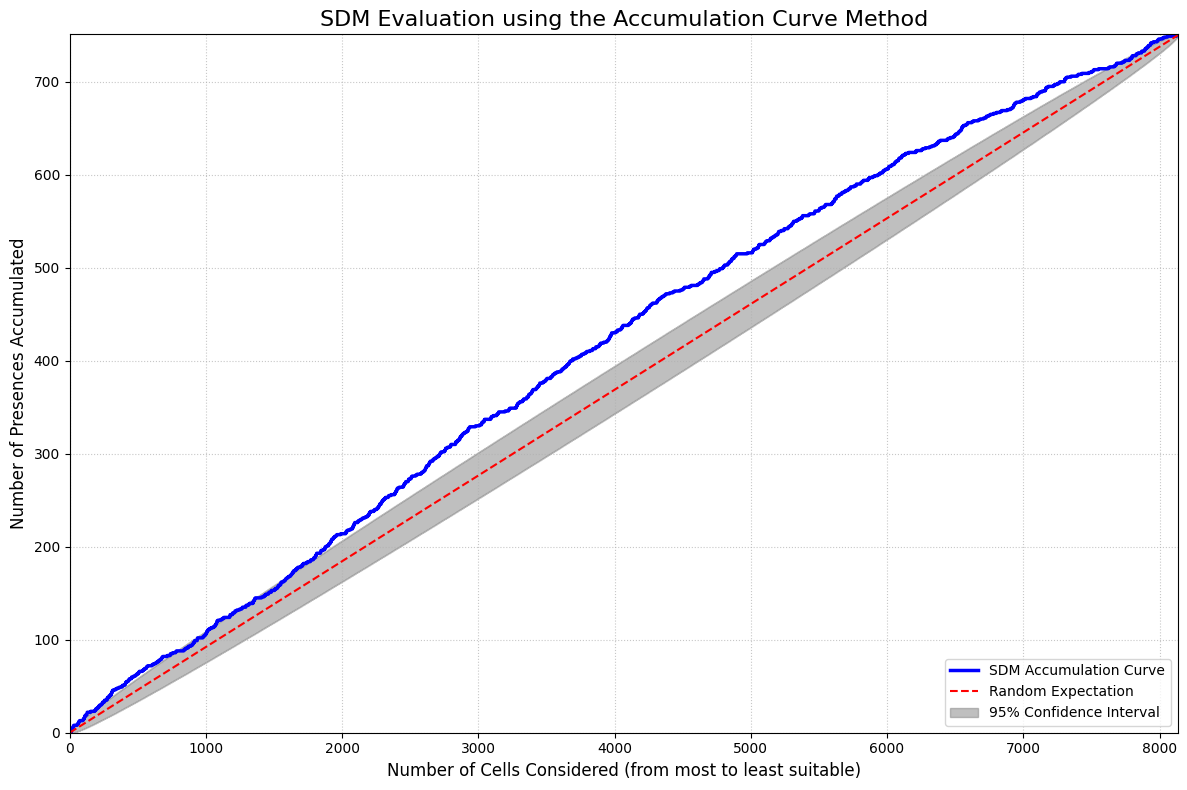

In [145]:
bat_model_params = {'C': 0.01, 'class_weight': None, 'max_iter': 300, 'penalty': 'l2', 'solver': 'newton-cg'}

bat_model = LogisticRegression(**bat_model_params, random_state=42)
bat_model.fit(bat_train_X, bat_train_y)
print("Boyce Index train:")
bat_probas = bat_model.predict_proba(bat_train_X)[:, 1]
print(boyce_index(bat_probas, bat_train_y))
print("Boyce Index test:")
bat_probas = bat_model.predict_proba(bat_test_X)[:, 1]
print(boyce_index(bat_probas, bat_test_y))
X_full = pd.concat([bat_train_X, bat_test_X], axis=0)
plot_accumulation_curve(bat_model, X_full, bat_test_y)

ROC AUC train:
0.6080147048950459
ROC AUC test:
0.5982455340174838


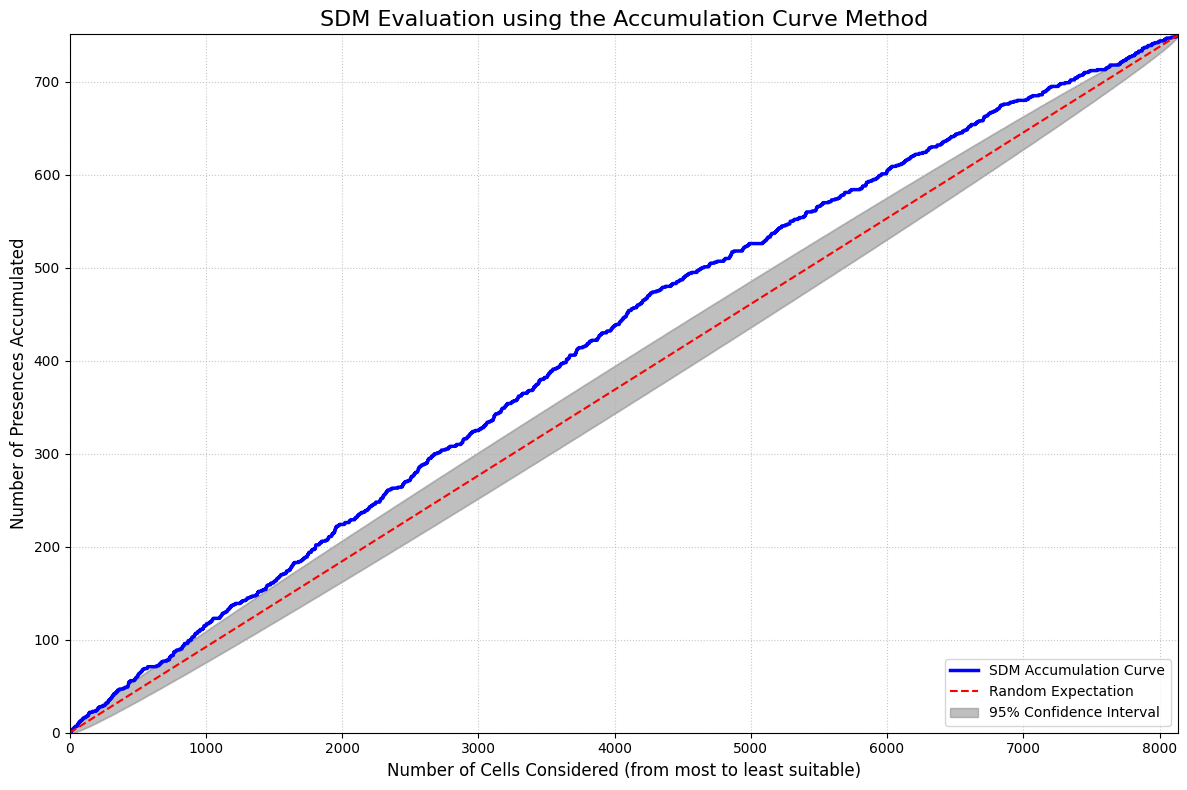

In [146]:
bat_model_params = {'C': 100, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
bat_model = LogisticRegression(**bat_model_params, random_state=42)
bat_model.fit(bat_train_X, bat_train_y)
print("ROC AUC train:")
from sklearn.metrics import roc_auc_score
bat_probas = bat_model.predict_proba(bat_train_X)[:, 1]
print(roc_auc_score(bat_train_y, bat_probas))
print("ROC AUC test:")
bat_probas = bat_model.predict_proba(bat_test_X)[:, 1]
print(roc_auc_score(bat_test_y, bat_probas))
X_full = pd.concat([bat_train_X, bat_test_X], axis=0)
plot_accumulation_curve(bat_model, X_full, bat_test_y)


In [107]:
# Create and fit the grid search using Boyce Index
grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,
    scoring=boyce_scorer,
    n_jobs=-1,
)

grid_search.fit(brown_hare_train_X, brown_hare_train_y)
print("Best parameters found for Brown Hare: ", grid_search.best_params_)
print("Best Boyce Index score for Brown Hare: ", grid_search.best_score_)

/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

Best parameters found for Brown Hare:  {'C': 100, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'saga'}
Best Boyce Index score for Brown Hare:  0.9019762732827322


In [108]:
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(brown_hare_train_X, brown_hare_train_y)
print("Best parameters found for Brown Hare: ", grid_search.best_params_)
print("Best ROC AUC score for Brown Hare: ", grid_search.best_score_)

/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

Best parameters found for Brown Hare:  {'C': 10, 'class_weight': 'balanced', 'max_iter': 300, 'penalty': 'l1', 'solver': 'liblinear'}
Best ROC AUC score for Brown Hare:  0.7096533519481906


Boyce Index train for Brown Hare:
0.691771694271092
Boyce Index test for Brown Hare:
0.6682487155057172


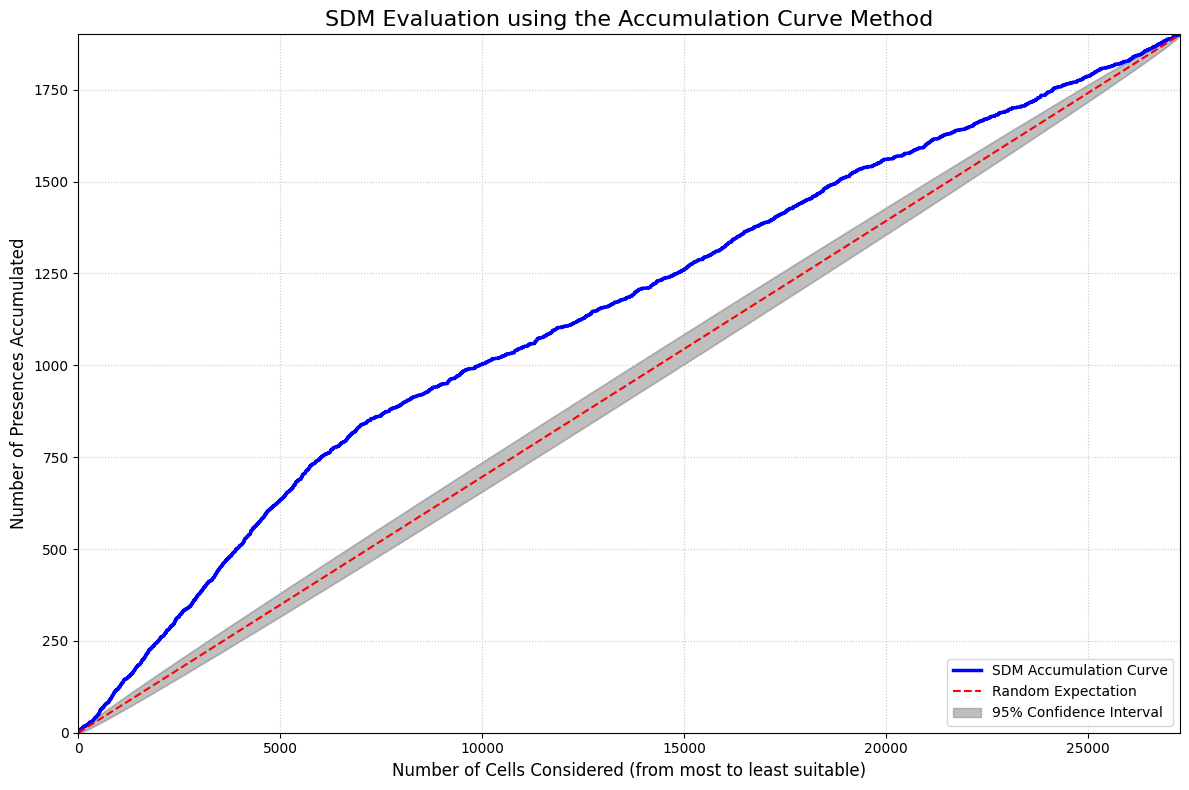

In [147]:
brown_hare_model_params = {'C': 100, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'saga'}
brown_hare_model = LogisticRegression(**brown_hare_model_params, random_state=42, n_jobs=-1)
brown_hare_model.fit(brown_hare_train_X, brown_hare_train_y)
print("Boyce Index train for Brown Hare:")
brown_hare_probas = brown_hare_model.predict_proba(brown_hare_train_X)[:, 1]
print(boyce_index(brown_hare_probas, brown_hare_train_y))
print("Boyce Index test for Brown Hare:")
brown_hare_probas = brown_hare_model.predict_proba(brown_hare_test_X)[:, 1]
print(boyce_index(brown_hare_probas, brown_hare_test_y))
X_full = pd.concat([brown_hare_train_X, brown_hare_test_X], axis=0)
plot_accumulation_curve(brown_hare_model, X_full, brown_hare_test_y)


ROC AUC train for Brown Hare:
0.7115499078462277
ROC AUC test for Brown Hare:
0.6993824857502405


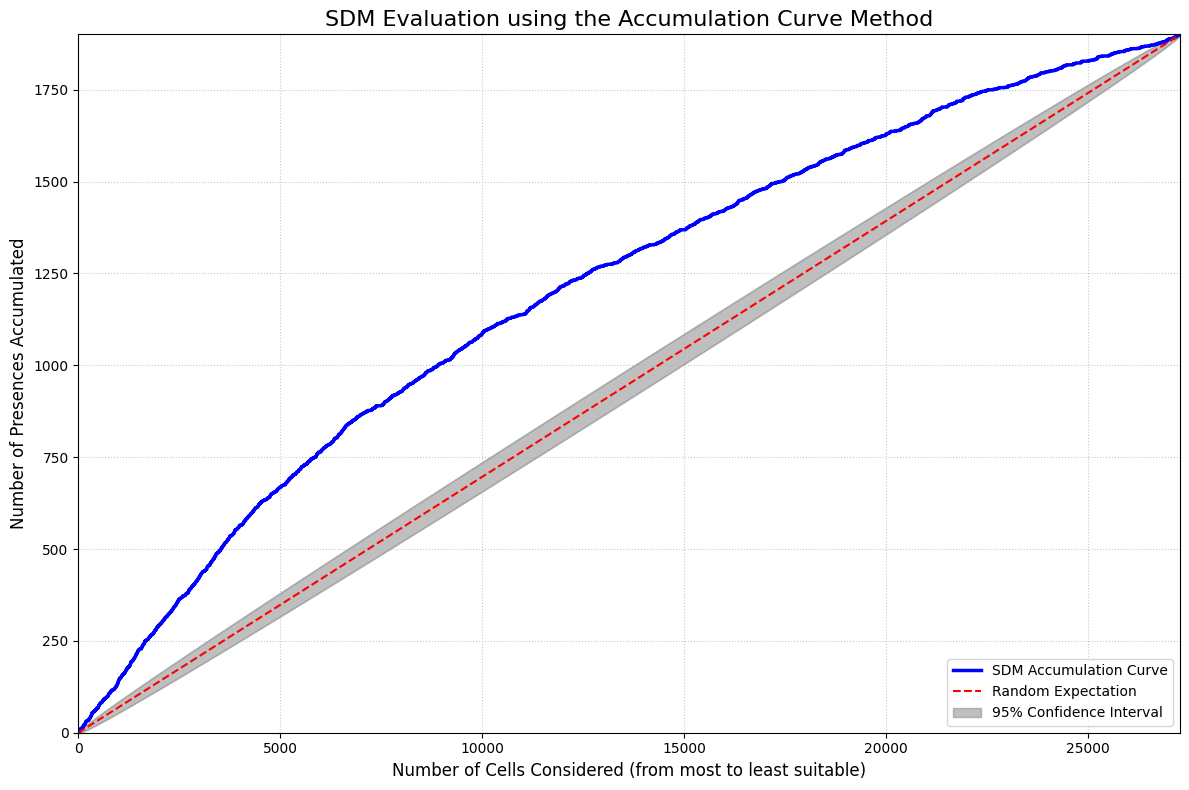

In [148]:
brown_hare_model_params = {'C': 10, 'class_weight': 'balanced', 'max_iter': 300, 'penalty': 'l1', 'solver': 'liblinear'}
brown_hare_model = LogisticRegression(**brown_hare_model_params, random_state=42)
brown_hare_model.fit(brown_hare_train_X, brown_hare_train_y)
print("ROC AUC train for Brown Hare:")
brown_hare_probas = brown_hare_model.predict_proba(brown_hare_train_X)[:, 1]
print(roc_auc_score(brown_hare_train_y, brown_hare_probas))
print("ROC AUC test for Brown Hare:")
brown_hare_probas = brown_hare_model.predict_proba(brown_hare_test_X)[:, 1]
print(roc_auc_score(brown_hare_test_y, brown_hare_probas))
X_full = pd.concat([brown_hare_train_X, brown_hare_test_X], axis=0)
plot_accumulation_curve(brown_hare_model, X_full, brown_hare_test_y)

In [116]:
# Create and fit the grid search using Boyce Index
grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,
    scoring=boyce_scorer,
    n_jobs=-1,
)

grid_search.fit(dormice_train_X, dormice_train_y)
print("Best parameters found for Dormice: ", grid_search.best_params_)
print("Best Boyce Index score for Dormice: ", grid_search.best_score_)

/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/li

Best parameters found for Dormice:  {'C': 100, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Boyce Index score for Dormice:  0.9206886140520705


In [117]:
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(dormice_train_X, dormice_train_y)
print("Best parameters found for Dormice: ", grid_search.best_params_)
print("Best ROC AUC score for Dormice: ", grid_search.best_score_)

/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/li

Best parameters found for Dormice:  {'C': 10, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best ROC AUC score for Dormice:  0.7439746050963021


/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Boyce Index train for Dormice:
0.9258571146533431
Boyce Index test for Dormice:
0.8808402531075672


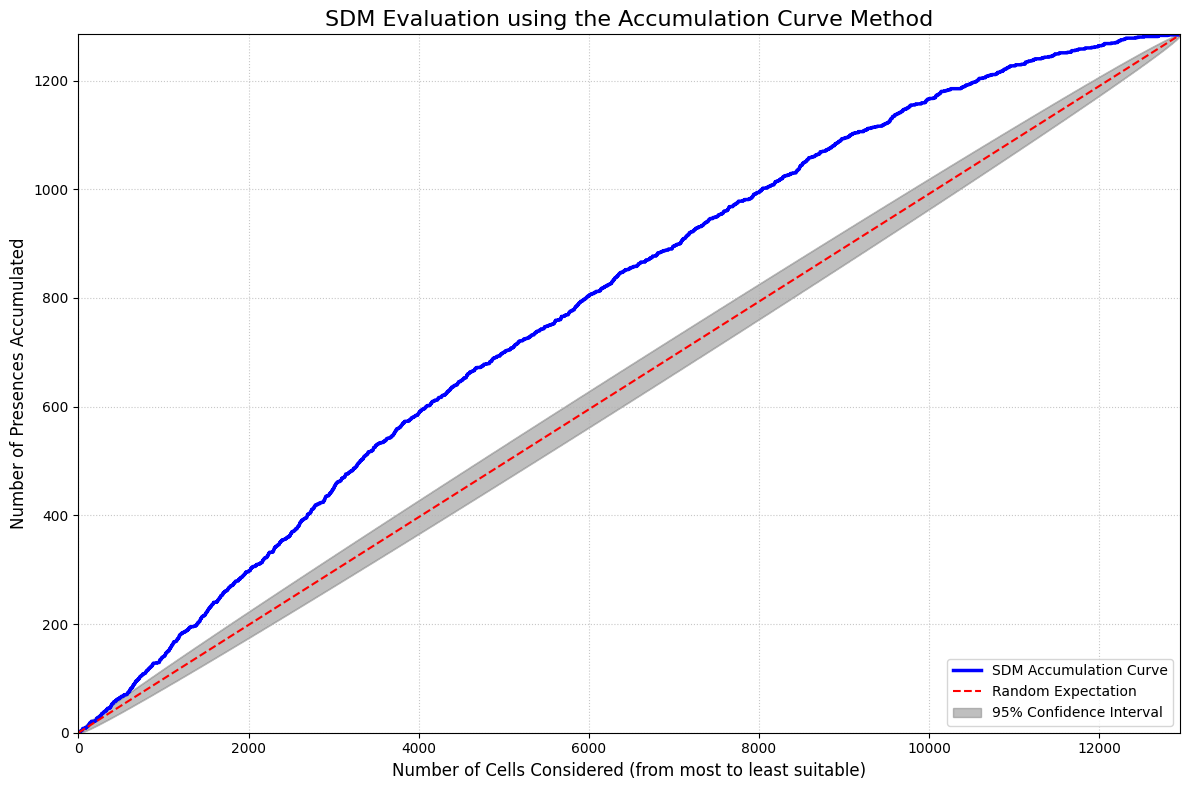

In [149]:
dormice_model_params = {'C': 100, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
dormice_model = LogisticRegression(**dormice_model_params, random_state=42, n_jobs=-1)
dormice_model.fit(dormice_train_X, dormice_train_y)
print("Boyce Index train for Dormice:")
dormice_probas = dormice_model.predict_proba(dormice_train_X)[:, 1]
print(boyce_index(dormice_probas, dormice_train_y))
print("Boyce Index test for Dormice:")
dormice_probas = dormice_model.predict_proba(dormice_test_X)[:, 1]
print(boyce_index(dormice_probas, dormice_test_y))
X_full = pd.concat([dormice_train_X, dormice_test_X], axis=0)
plot_accumulation_curve(dormice_model, X_full, dormice_test_y)

ROC AUC train for Dormice:
0.7467687568110091
ROC AUC test for Dormice:
0.7391514362181736


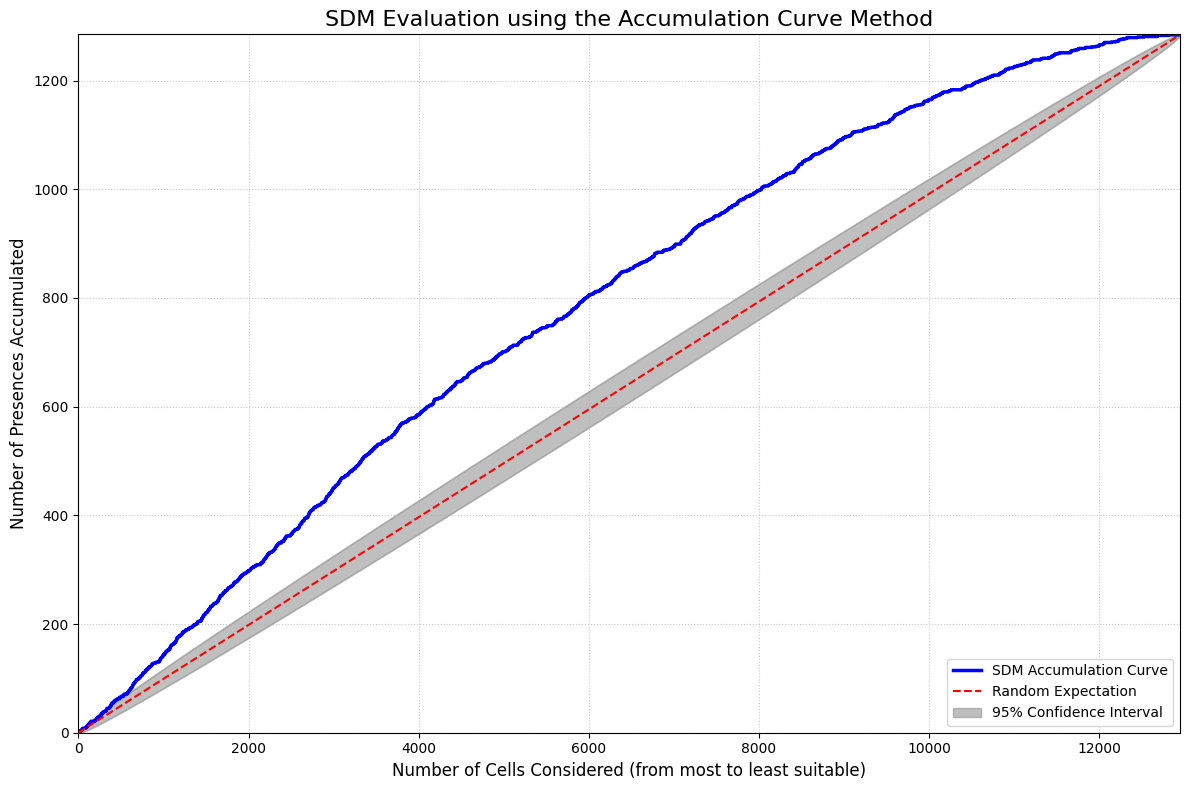

In [152]:
dormice_model_params = {'C': 10, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
dormice_model = LogisticRegression(**dormice_model_params, random_state=42)
dormice_model.fit(dormice_train_X, dormice_train_y)
print("ROC AUC train for Dormice:")
dormice_probas = dormice_model.predict_proba(dormice_train_X)[:, 1]
print(roc_auc_score(dormice_train_y, dormice_probas))
print("ROC AUC test for Dormice:")
dormice_probas = dormice_model.predict_proba(dormice_test_X)[:, 1]
print(roc_auc_score(dormice_test_y, dormice_probas))
X_full = pd.concat([dormice_train_X, dormice_test_X], axis=0)
plot_accumulation_curve(dormice_model, X_full, dormice_test_y)

In [153]:
# Create and fit the grid search using Boyce Index
grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,
    scoring=boyce_scorer,
    n_jobs=-1,
)

grid_search.fit(hedgehog_train_X, hedgehog_train_y)
print("Best parameters found for Hedgehog: ", grid_search.best_params_)
print("Best Boyce Index score for Hedgehog: ", grid_search.best_score_)

/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

Best parameters found for Hedgehog:  {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 300, 'penalty': 'l1', 'solver': 'saga'}
Best Boyce Index score for Hedgehog:  0.8421583710690511


/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [154]:
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(hedgehog_train_X, hedgehog_train_y)
print("Best parameters found for Hedgehog: ", grid_search.best_params_)
print("Best ROC AUC score for Hedgehog: ", grid_search.best_score_)

/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

Best parameters found for Hedgehog:  {'C': 1, 'class_weight': 'balanced', 'max_iter': 300, 'penalty': 'l2', 'solver': 'newton-cg'}
Best ROC AUC score for Hedgehog:  0.8371493580589051


Boyce Index train for Hedgehog:
0.5349686802633488
Boyce Index test for Hedgehog:
0.44604215441895073


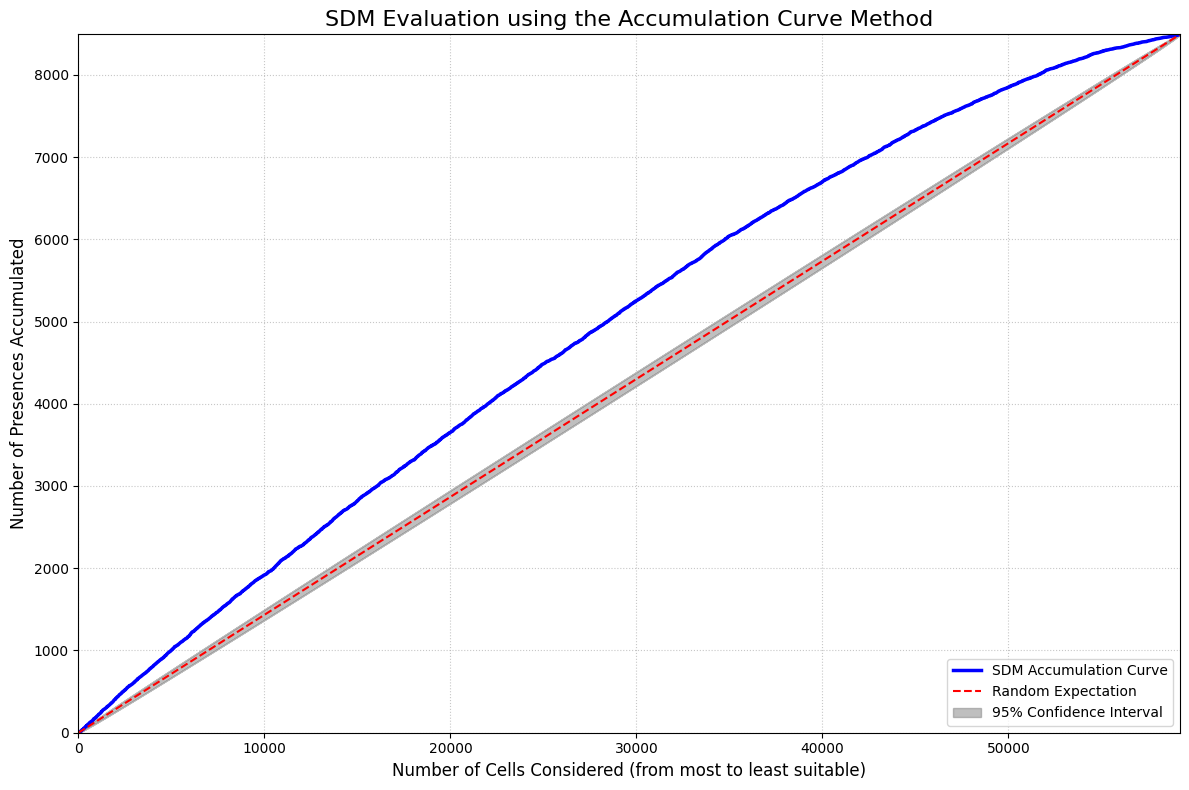

In [160]:
hedgehog_model_params = {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l1', 'solver': 'saga'}
hedgehog_model = LogisticRegression(**hedgehog_model_params, random_state=42)
hedgehog_model.fit(hedgehog_train_X, hedgehog_train_y)
print("Boyce Index train for Hedgehog:")
hedgehog_probas = hedgehog_model.predict_proba(hedgehog_train_X)[:, 1]
print(boyce_index(hedgehog_probas, hedgehog_train_y))
print("Boyce Index test for Hedgehog:")
hedgehog_probas = hedgehog_model.predict_proba(hedgehog_test_X)[:, 1]
print(boyce_index(hedgehog_probas, hedgehog_test_y))
X_full = pd.concat([hedgehog_train_X, hedgehog_test_X], axis=0)
plot_accumulation_curve(hedgehog_model, X_full, hedgehog_test_y)

ROC AUC train for Hedgehog:
0.8376853609957351
ROC AUC test for Hedgehog:
0.8365754276143663


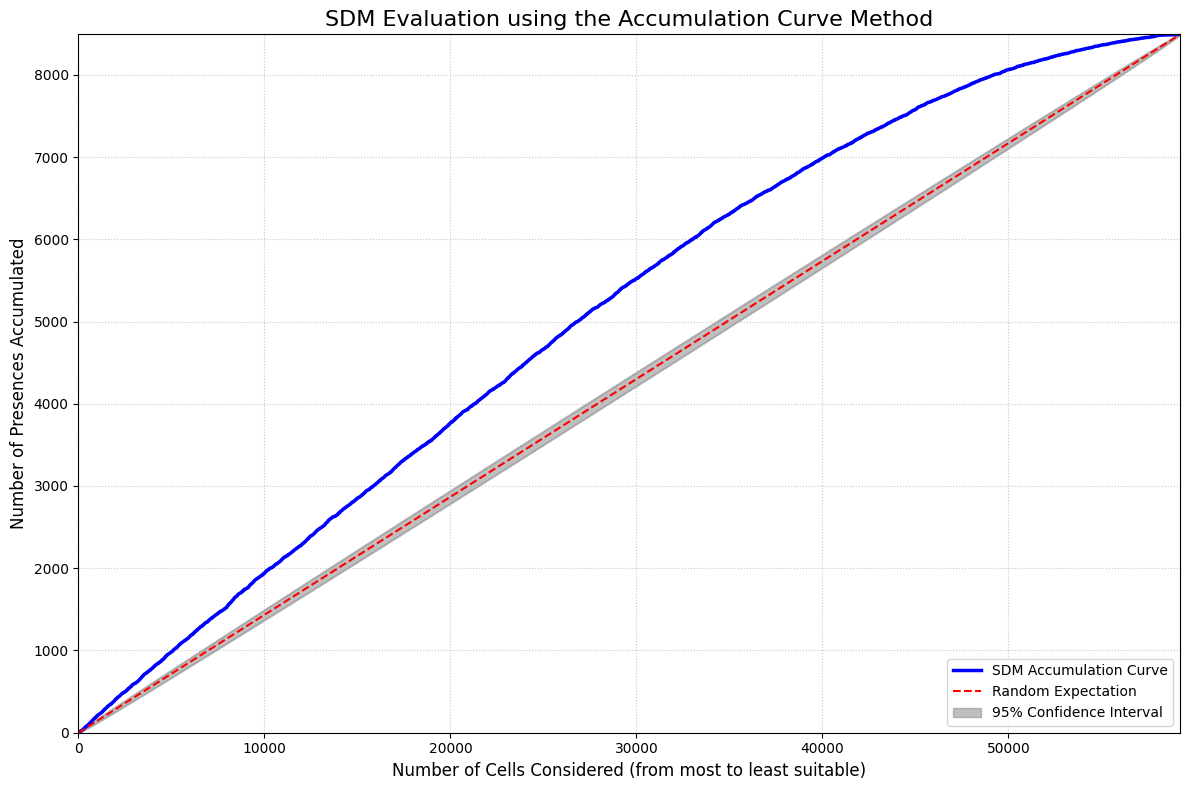

In [158]:
hedgehog_model_params = {'C': 1, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}
hedgehog_model = LogisticRegression(**hedgehog_model_params, random_state=42)
hedgehog_model.fit(hedgehog_train_X, hedgehog_train_y)
print("ROC AUC train for Hedgehog:")
hedgehog_probas = hedgehog_model.predict_proba(hedgehog_train_X)[:, 1]
print(roc_auc_score(hedgehog_train_y, hedgehog_probas))
print("ROC AUC test for Hedgehog:")
hedgehog_probas = hedgehog_model.predict_proba(hedgehog_test_X)[:, 1]
print(roc_auc_score(hedgehog_test_y, hedgehog_probas))
X_full = pd.concat([hedgehog_train_X, hedgehog_test_X], axis=0)
plot_accumulation_curve(hedgehog_model, X_full, hedgehog_test_y)

In [155]:
# Create and fit the grid search using Boyce Index
grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,
    scoring=boyce_scorer,
    n_jobs=-1,
)

grid_search.fit(red_squirrel_train_X, red_squirrel_train_y)
print("Best parameters found for Red Squirrel: ", grid_search.best_params_)
print("Best Boyce Index score for Red Squirrel: ", grid_search.best_score_)

/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/li

Best parameters found for Red Squirrel:  {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Boyce Index score for Red Squirrel:  0.8274130993886775


/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [156]:
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(red_squirrel_train_X, red_squirrel_train_y)
print("Best parameters found for Red Squirrel: ", grid_search.best_params_)
print("Best ROC AUC score for Red Squirrel: ", grid_search.best_score_)

/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/li

Best parameters found for Red Squirrel:  {'C': 1, 'class_weight': None, 'max_iter': 300, 'penalty': 'l1', 'solver': 'liblinear'}
Best ROC AUC score for Red Squirrel:  0.9337478483692319


/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
3120 fits failed out of a total of 4800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^

Boyce Index train for Red Squirrel:
0.8013059514161448
Boyce Index test for Red Squirrel:
0.8591993098600667


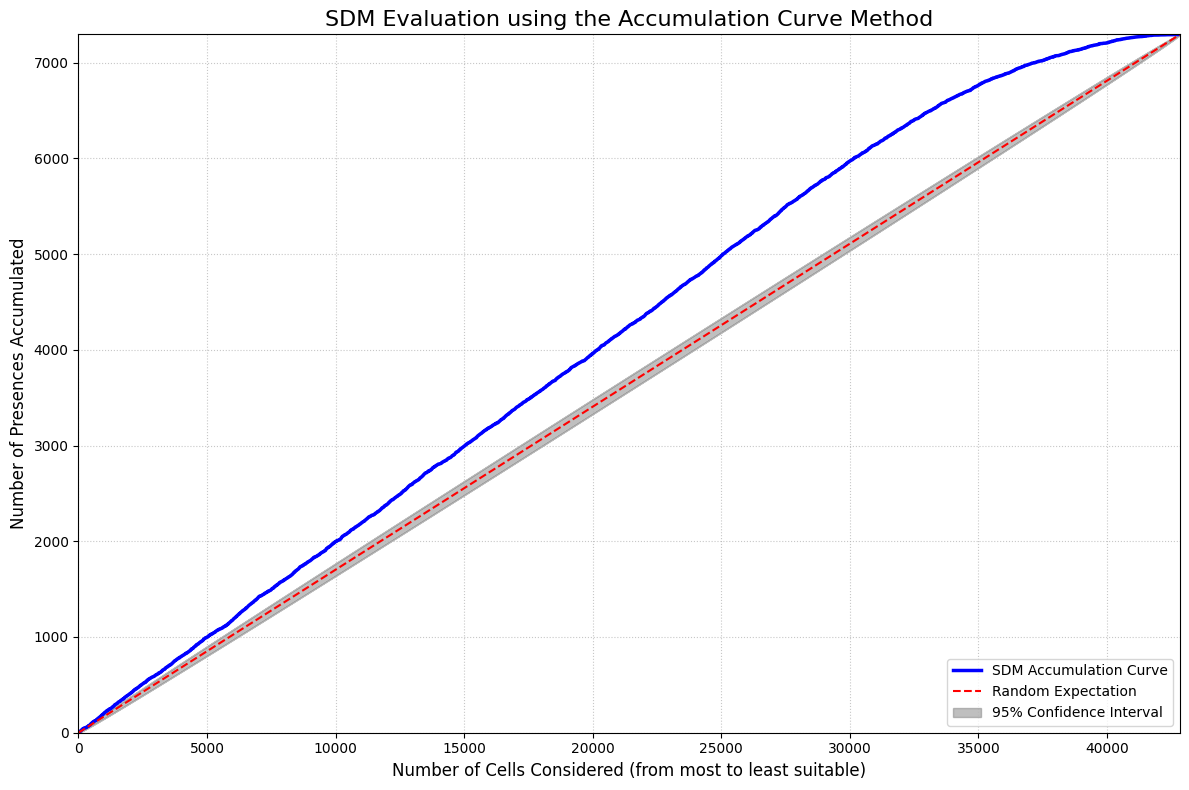

In [162]:
red_squirrel_model_params = {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
red_squirrel_model = LogisticRegression(**red_squirrel_model_params, random_state=42)
red_squirrel_model.fit(red_squirrel_train_X, red_squirrel_train_y)
print("Boyce Index train for Red Squirrel:")
red_squirrel_probas = red_squirrel_model.predict_proba(red_squirrel_train_X)[:, 1]
print(boyce_index(red_squirrel_probas, red_squirrel_train_y))
print("Boyce Index test for Red Squirrel:")
red_squirrel_probas = red_squirrel_model.predict_proba(red_squirrel_test_X)[:, 1]
print(boyce_index(red_squirrel_probas, red_squirrel_test_y))
X_full = pd.concat([red_squirrel_train_X, red_squirrel_test_X], axis=0)
plot_accumulation_curve(red_squirrel_model, X_full, red_squirrel_test_y)

ROC AUC train for Red Squirrel:
0.9403861619712959
ROC AUC test for Red Squirrel:
0.9462722635193159


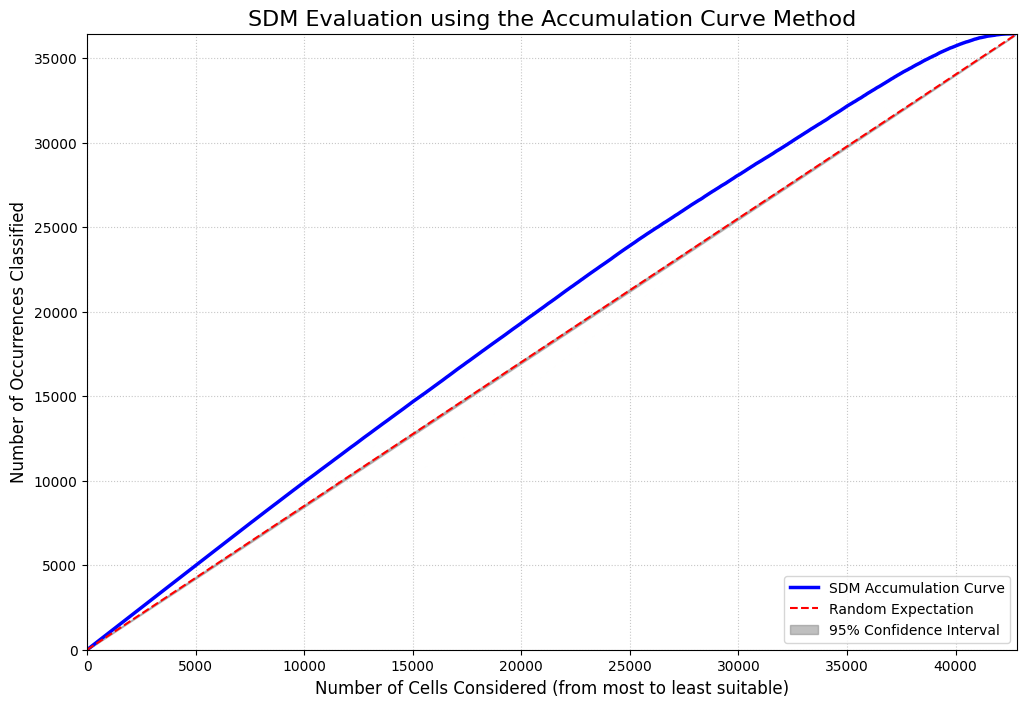

In [94]:
red_squirrel_model_params = {'C': 1, 'class_weight': None, 'max_iter': 300, 'penalty': 'l1', 'solver': 'liblinear'}
red_squirrel_model = LogisticRegression(**red_squirrel_model_params, random_state=42)
red_squirrel_model.fit(red_squirrel_train_X, red_squirrel_train_y)
print("ROC AUC train for Red Squirrel:")
red_squirrel_probas = red_squirrel_model.predict_proba(red_squirrel_train_X)[:, 1]
print(roc_auc_score(red_squirrel_train_y, red_squirrel_probas))
print("ROC AUC test for Red Squirrel:")
red_squirrel_probas = red_squirrel_model.predict_proba(red_squirrel_test_X)[:, 1]
print(roc_auc_score(red_squirrel_test_y, red_squirrel_probas))
X_full = pd.concat([red_squirrel_train_X, red_squirrel_test_X], axis=0)
plot_accumulation_curve(red_squirrel_model, X_full, red_squirrel_test_y)

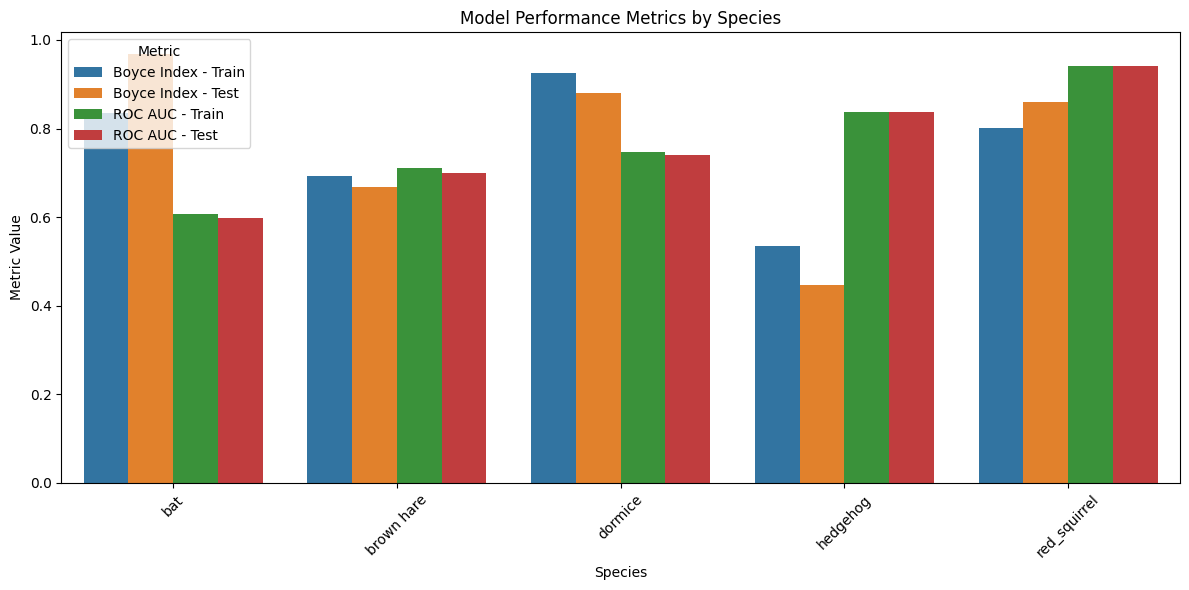

In [163]:
results = pd.DataFrame(columns=['species', 'metric', 'value'])
values = [['bat', 'Boyce Index - Train', 0.8340307029340625],
          ['bat', 'Boyce Index - Test', 0.9687805410872675],
          ['bat', 'ROC AUC - Train', 0.6080147048950459],
          ['bat', 'ROC AUC - Test', 0.5982455340174838],
          ['brown hare', 'Boyce Index - Train', 0.691771694271092],
          ['brown hare', 'Boyce Index - Test', 0.6682487155057172],
          ['brown hare', 'ROC AUC - Train', 0.7115499078462277],
          ['brown hare', 'ROC AUC - Test', 0.6993824857502405],
          ['dormice', 'Boyce Index - Train', 0.9258571146533431],
          ['dormice', 'Boyce Index - Test', 0.8808402531075672],
          ['dormice', 'ROC AUC - Train', 0.7467687568110091],
          ['dormice', 'ROC AUC - Test', 0.7391514362181736],
          ['hedgehog', 'Boyce Index - Train', 0.5349686802633488],
          ['hedgehog', 'Boyce Index - Test', 0.44604215441895073],
          ['hedgehog', 'ROC AUC - Train', 0.8376853609957351],
          ['hedgehog', 'ROC AUC - Test', 0.8365754276143663],
          ['red_squirrel', 'Boyce Index - Train', 0.8013059514161448],
          ['red_squirrel', 'Boyce Index - Test', 0.8591993098600667],
          ['red_squirrel', 'ROC AUC - Train', 0.9403861619712959],
          ['red_squirrel', 'ROC AUC - Test', 0.9403861619712959],
          ]
for value in values:
    results = pd.concat([results, pd.DataFrame([[value[0], value[1], value[2]]], columns=results.columns)], ignore_index=True)

#plot for each species a multi-bar chart with the metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.barplot(data=results, x='species', y='value', hue='metric')
plt.title('Model Performance Metrics by Species')
plt.xlabel('Species')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()